In [1]:
# Import necessary libraries and configure logging
import logging
from pathlib import Path
from typing import Tuple, Union, Optional, Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from prophet import Prophet
import pmdarima as pm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


C:\Users\wal\AppData\Local\Temp\ipykernel_15648\158561055.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Section 2: Load Data
def load_data(filepath: Union[str, Path]) -> Optional[pd.DataFrame]:
    """Load stock data from a CSV file."""
    try:
        data = pd.read_csv(filepath)
        data['date'] = pd.to_datetime(data['date'])
        required_columns = {'date', 'open', 'high', 'low', 'close', 'volume', 'Name'}
        missing_columns = required_columns - set(data.columns)
        if missing_columns:
            raise ValueError(f"Missing columns: {missing_columns}")
        logger.info("Data loaded successfully.")
        return data
    except Exception as e:
        logger.error(f"Error loading data: {e}")
        return None

filepath = 'all_stocks_5yr.csv'
data = load_data(filepath)
data.head()


2024-05-18 10:37:43,097 - INFO - Data loaded successfully.


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [ ]:
# Section 3: Explore Data
def explore_data(data: pd.DataFrame) -> pd.DataFrame:
    """Explore the data and log important characteristics."""
    exploration_report = []
    
    for col in data.columns:
        col_type = data[col].dtype
        missing_percentage = data[col].isnull().mean() * 100
        unique_values = data[col].nunique()
        outliers = ((np.abs(zscore(data[col])) > 3).sum()) if np.issubdtype(col_type, np.number) else 'N/A'
        exploration_report.append({
            "Name": col,
            "Type": col_type,
            "Missing Percentage": missing_percentage,
            "Unique Values": unique_values,
            "Outliers": outliers
        })
        
        logger.info(f"Feature '{col}' - Type: {col_type}, Missing: {missing_percentage:.2f}%, Unique: {unique_values}, Outliers: {outliers}")
    
    exploration_df = pd.DataFrame(exploration_report)
    logger.info(f"Exploration Report:\n{exploration_df}")
    return exploration_df

exploration_report = explore_data(data)
exploration_report


2024-05-18 10:37:43,121 - INFO - Feature 'date' - Type: datetime64[ns], Missing: 0.00%, Unique: 1259, Outliers: N/A
2024-05-18 10:37:43,152 - INFO - Feature 'open' - Type: float64, Missing: 0.00%, Unique: 49715, Outliers: 0
2024-05-18 10:37:43,183 - INFO - Feature 'high' - Type: float64, Missing: 0.00%, Unique: 81499, Outliers: 0
2024-05-18 10:37:43,215 - INFO - Feature 'low' - Type: float64, Missing: 0.00%, Unique: 82354, Outliers: 0
2024-05-18 10:37:43,247 - INFO - Feature 'close' - Type: float64, Missing: 0.00%, Unique: 51151, Outliers: 8508
2024-05-18 10:37:43,292 - INFO - Feature 'volume' - Type: int64, Missing: 0.00%, Unique: 586441, Outliers: 9570
2024-05-18 10:37:43,322 - INFO - Feature 'Name' - Type: object, Missing: 0.00%, Unique: 505, Outliers: N/A
2024-05-18 10:37:43,324 - INFO - Exploration Report:
     Name            Type  Missing Percentage  Unique Values Outliers
0    date  datetime64[ns]            0.000000           1259      N/A
1    open         float64            

,Name,Type,Missing Percentage,Unique Values,Outliers
0,date,datetime64[ns],0.000000,1259,N/A
1,open,float64,0.001777,49715,0
2,high,float64,0.001292,81499,0
3,low,float64,0.001292,82354,0
4,close,float64,0.000000,51151,8508
5,volume,int64,0.000000,586441,9570
6,Name,object,0.000000,505,N/A


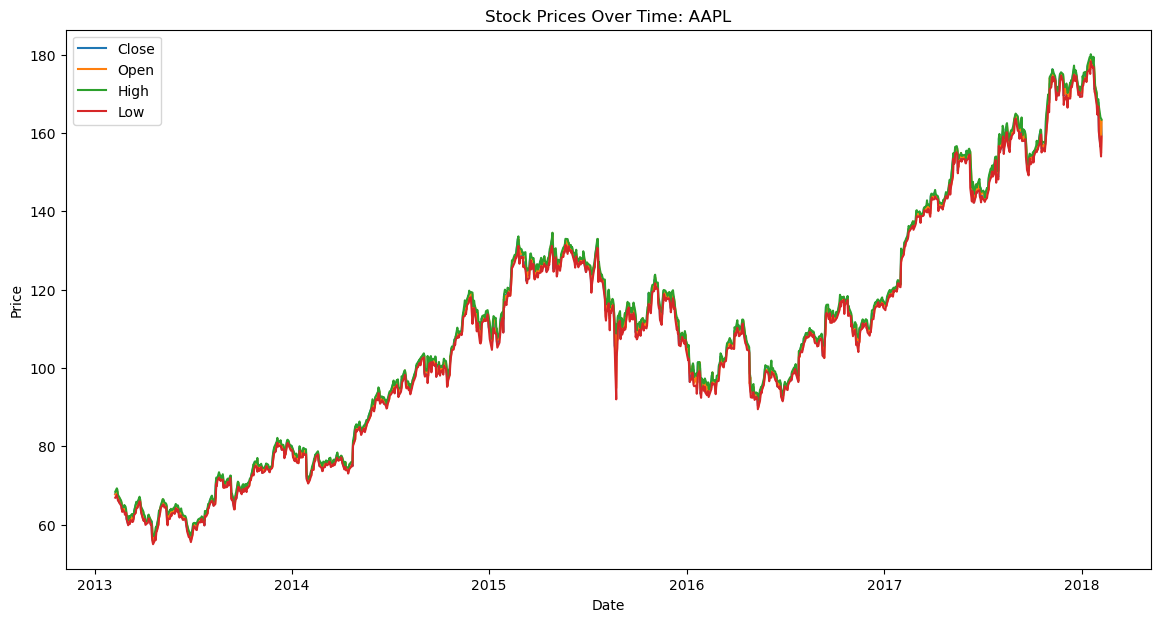

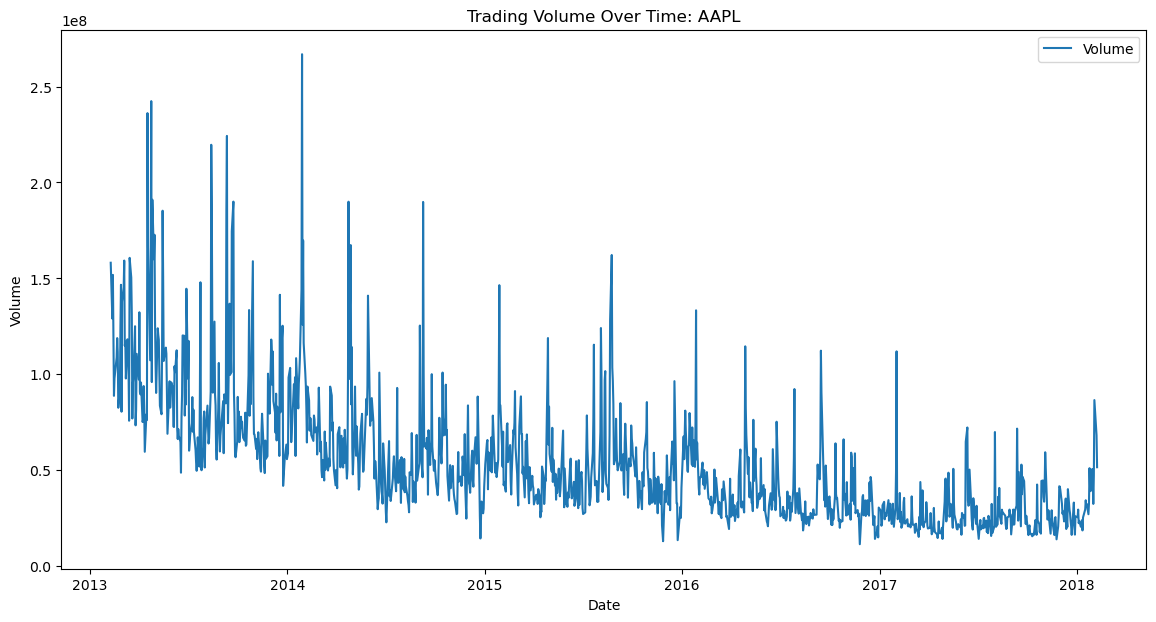

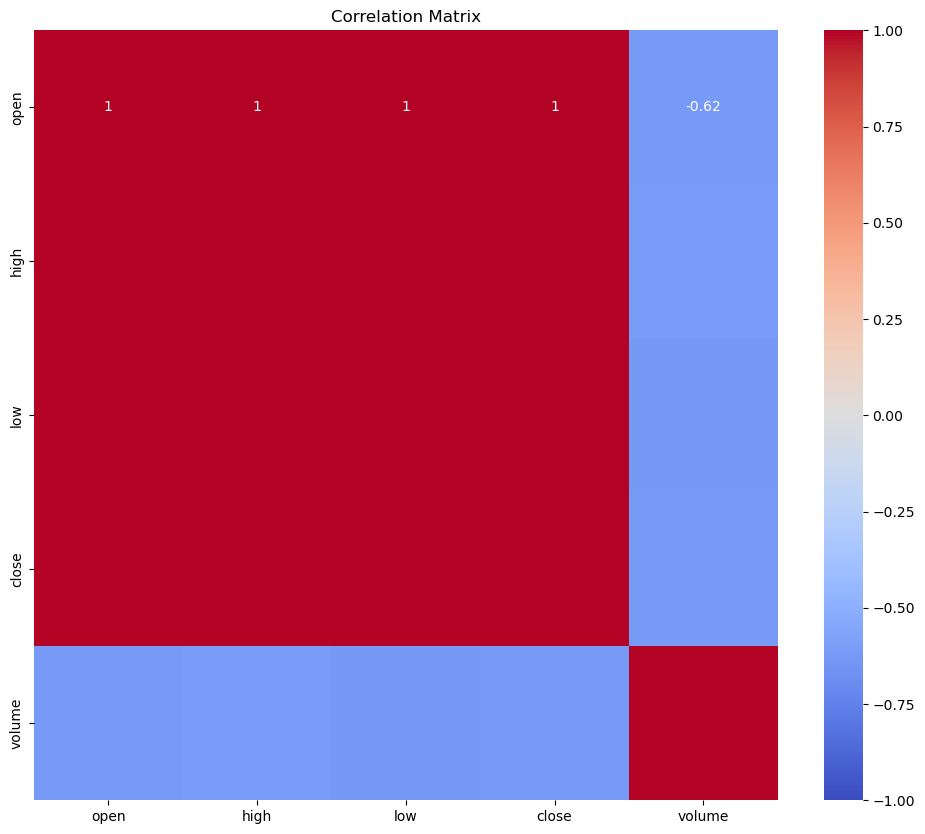

In [ ]:
# Section 4: Visualize Data
def visualize_data(stock_data: pd.DataFrame, stock_name: str) -> None:
    """Visualize stock prices and trading volume over time."""
    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['date'], stock_data['close'], label='Close')
    plt.plot(stock_data['date'], stock_data['open'], label='Open')
    plt.plot(stock_data['date'], stock_data['high'], label='High')
    plt.plot(stock_data['date'], stock_data['low'], label='Low')
    plt.legend()
    plt.title(f'Stock Prices Over Time: {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(stock_data['date'], stock_data['volume'], label='Volume')
    plt.legend()
    plt.title(f'Trading Volume Over Time: {stock_name}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()

def plot_correlation_matrix(stock_data: pd.DataFrame) -> None:
    """Plot the correlation matrix of the stock data features."""
    features = [col for col in stock_data.columns if col not in ['date', 'Name']]
    corr_matrix = stock_data[features].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

stock_name = 'AAPL'
stock_data = data[data['Name'] == stock_name]
visualize_data(stock_data, stock_name)
plot_correlation_matrix(stock_data)


In [ ]:
# Section 5: Clean and Engineer Features

def calculate_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
    """Calculate the Relative Strength Index (RSI) for a given series of prices."""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices: pd.Series, short_period: int = 12, long_period: int = 26, signal_period: int = 9) -> Tuple[pd.Series, pd.Series]:
    """Calculate the Moving Average Convergence Divergence (MACD) for a given series of prices."""
    short_ema = prices.ewm(span=short_period, adjust=False).mean()
    long_ema = prices.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

def calculate_bollinger_bands(prices: pd.Series, window: int = 20, num_std: int = 2) -> Tuple[pd.Series, pd.Series]:
    """Calculate Bollinger Bands for a given series of prices."""
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

def engineer_features(data: pd.DataFrame) -> pd.DataFrame:
    """Engineer features for the stock data."""
    if data['volume'].skew() > 1:
        data['log_volume'] = np.log1p(data['volume'])
    data['prev_close'] = data['close'].shift(1)
    ma_windows = [7, 14, 21]
    for window in ma_windows:
        data[f'{window}_day_ma'] = data['close'].rolling(window=window).mean()
    data['rsi'] = calculate_rsi(data['close'])
    data['macd'], data['signal_line'] = calculate_macd(data['close'])
    data['bollinger_upper'], data['bollinger_lower'] = calculate_bollinger_bands(data['close'])
    data['pct_change'] = data['close'].pct_change()
    data['volatility'] = data['close'].rolling(window=14).std()
    
    # Lag features
    for lag in range(1, 4):
        data[f'lag_{lag}'] = data['close'].shift(lag)
        
    data.dropna(inplace=True)
    logger.info("Features engineered.")
    return data

cleaned_data = clean_data(stock_data)
engineered_data = engineer_features(cleaned_data)
engineered_data.head()


C:\Users\bhupa\AppData\Local\Temp\ipykernel_23732\1397350814.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
2024-05-18 10:50:09,505 - INFO - Data cleaned with forward fill.
2024-05-18 10:50:09,514 - INFO - Features engineered.


,date,open,high,low,close,volume,Name,log_volume,prev_close,7_day_ma,...,rsi,macd,signal_line,bollinger_upper,bollinger_lower,pct_change,volatility,lag_1,lag_2,lag_3
1279,2013-03-11,61.3928,62.7157,60.7342,62.5528,118272126,AAPL,18.588499,61.6742,61.377457,...,37.787534,-1.501781,-1.427244,68.445510,59.162060,0.014246,1.382457,61.6742,61.5117,60.8088
1280,2013-03-12,62.2285,62.6971,61.0814,61.2042,116268341,AAPL,18.571411,62.5528,61.335814,...,38.510256,-1.495274,-1.440850,67.635127,59.236723,-0.021559,1.348564,62.5528,61.6742,61.5117
1281,2013-03-13,61.2071,62.0714,60.7657,61.1928,101369051,AAPL,18.434278,61.2042,61.505200,...,39.721798,-1.474045,-1.447489,67.142538,59.164312,-0.000186,1.320007,61.2042,62.5528,61.6742
1282,2013-03-14,61.8328,62.0914,61.4928,61.7857,75834906,AAPL,18.144069,61.1928,61.532886,...,39.299127,-1.393318,-1.436655,66.564748,59.249112,0.009689,1.154921,61.1928,61.2042,62.5528
1283,2013-03-15,62.5614,63.4614,62.4642,63.3799,160710606,AAPL,18.895116,61.7857,61.900186,...,50.484540,-1.187019,-1.386728,65.961118,59.525172,0.025802,1.165743,61.7857,61.1928,61.2042


In [ ]:
# Section 6: Scale Features
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: float = 3.0):
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'OutlierHandler':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        for col in X.columns:
            z_scores = zscore(X[col])
            X[col] = np.where(np.abs(z_scores) > self.threshold, np.median(X[col]), X[col])
        return X

def scale_features(data: pd.DataFrame) -> Tuple[pd.DataFrame, RobustScaler]:
    """Scale features using RobustScaler."""
    scaler = RobustScaler()
    features = ['open', 'high', 'low', 'close', 'volume']
    data[features] = scaler.fit_transform(data[features])
    logger.info("Features scaled.")
    return data, scaler

scaled_data, scaler = scale_features(engineered_data)
scaled_data.head()


2024-05-18 10:37:44,021 - INFO - Features scaled.


,date,open,high,low,close,volume,Name,log_volume,prev_close,7_day_ma,...,rsi,macd,signal_line,bollinger_upper,bollinger_lower,pct_change,volatility,lag_1,lag_2,lag_3
1279,2013-03-11,-1.279412,-1.275639,-1.291903,-1.263864,1.935324,AAPL,18.588499,61.6742,61.377457,...,37.787534,-1.501781,-1.427244,68.445510,59.162060,0.014246,1.382457,61.6742,61.5117,60.8088
1280,2013-03-12,-1.257061,-1.276137,-1.282481,-1.300278,1.882477,AAPL,18.571411,62.5528,61.335814,...,38.510256,-1.495274,-1.440850,67.635127,59.236723,-0.021559,1.348564,62.5528,61.6742,61.5117
1281,2013-03-13,-1.284378,-1.292890,-1.291049,-1.300586,1.489525,AAPL,18.434278,61.2042,61.505200,...,39.721798,-1.474045,-1.447489,67.142538,59.164312,-0.000186,1.320007,61.2042,62.5528,61.6742
1282,2013-03-14,-1.267644,-1.292354,-1.271317,-1.284577,0.816091,AAPL,18.144069,61.1928,61.532886,...,39.299127,-1.393318,-1.436655,66.564748,59.249112,0.009689,1.154921,61.1928,61.2042,62.5528
1283,2013-03-15,-1.248157,-1.255674,-1.244955,-1.241531,3.054591,AAPL,18.895116,61.7857,61.900186,...,50.484540,-1.187019,-1.386728,65.961118,59.525172,0.025802,1.165743,61.7857,61.1928,61.2042


In [ ]:
# Section 7: Save Transformed Data
def save_transformed_data(stock_data: pd.DataFrame, filename: Union[str, Path]) -> None:
    """Save the transformed stock data to a CSV file."""
    stock_data.to_csv(filename, index=False)
    logger.info(f"Transformed data saved to {filename}")

save_transformed_data(scaled_data, f"{stock_name}_transformed.csv")


2024-05-18 10:37:44,103 - INFO - Transformed data saved to AAPL_transformed.csv


In [ ]:
# Section 8: Prepare Time Series Data
def prepare_time_series_data(data: pd.DataFrame, target: str = 'close') -> pd.DataFrame:
    """Prepare the data for time series modeling."""
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    return data

time_series_data = prepare_time_series_data(scaled_data)
time_series_data.head()


,open,high,low,close,volume,Name,log_volume,prev_close,7_day_ma,14_day_ma,...,rsi,macd,signal_line,bollinger_upper,bollinger_lower,pct_change,volatility,lag_1,lag_2,lag_3
date,,,,,,,,,,,,,,,,,,,,,
2013-03-11,-1.279412,-1.275639,-1.291903,-1.263864,1.935324,AAPL,18.588499,61.6742,61.377457,62.560743,...,37.787534,-1.501781,-1.427244,68.445510,59.162060,0.014246,1.382457,61.6742,61.5117,60.8088
2013-03-12,-1.257061,-1.276137,-1.282481,-1.300278,1.882477,AAPL,18.571411,62.5528,61.335814,62.352371,...,38.510256,-1.495274,-1.440850,67.635127,59.236723,-0.021559,1.348564,62.5528,61.6742,61.5117
2013-03-13,-1.284378,-1.292890,-1.291049,-1.300586,1.489525,AAPL,18.434278,61.2042,61.505200,62.171657,...,39.721798,-1.474045,-1.447489,67.142538,59.164312,-0.000186,1.320007,61.2042,62.5528,61.6742
2013-03-14,-1.267644,-1.292354,-1.271317,-1.284577,0.816091,AAPL,18.144069,61.1928,61.532886,61.984821,...,39.299127,-1.393318,-1.436655,66.564748,59.249112,0.009689,1.154921,61.1928,61.2042,62.5528
2013-03-15,-1.248157,-1.255674,-1.244955,-1.241531,3.054591,AAPL,18.895116,61.7857,61.900186,61.993593,...,50.484540,-1.187019,-1.386728,65.961118,59.525172,0.025802,1.165743,61.7857,61.1928,61.2042


In [ ]:
# Section 9: Evaluate Model
def evaluate_model(true: pd.Series, predicted: np.ndarray) -> Tuple[float, float]:
    """Evaluate the model performance."""
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    return mse, mae

def time_series_cv(model: Union[BaseEstimator, Sequential], X: pd.DataFrame, y: pd.Series, n_splits: int = 3) -> Tuple[float, float]:
    """Perform time series cross-validation."""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mse_scores, mae_scores = [], []

    if hasattr(model, 'get_params'):  # Check if the model is a scikit-learn estimator
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse_scores.append(mean_squared_error(y_test, y_pred))
            mae_scores.append(mean_absolute_error(y_test, y_pred))
    else:  # Handle non-scikit-learn models (e.g., LSTM)
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
            early_stopping = EarlyStopping(monitor='val_loss', patience=5)
            model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

            X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
            y_pred = model.predict(X_test_reshaped)
            mse_scores.append(mean_squared_error(y_test, y_pred.flatten()))
            mae_scores.append(mean_absolute_error(y_test, y_pred.flatten()))

    mse = np.mean(mse_scores)
    mae = np.mean(mae_scores)
    logger.info(f"Cross-validation results - MSE: {mse:.4f}, MAE: {mae:.4f}")
    return mse, mae


In [ ]:
# Section 10: Train Models
def train_prophet(data: pd.DataFrame) -> Tuple[Prophet, float, float]:
    """Train a Prophet model."""
    prophet_data = data.reset_index().rename(columns={'date': 'ds', 'close': 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=len(data), freq='D')
    forecast = model.predict(future)
    predicted = forecast['yhat'].values[-len(data):]
    mse, mae = evaluate_model(data['close'], predicted)
    logger.info(f"Prophet model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return model, mse, mae

def train_auto_arima(data: pd.DataFrame) -> Tuple[pm.ARIMA, float, float]:
    """Train an Auto-ARIMA model."""
    model = pm.auto_arima(data['close'], seasonal=True, m=12)
    forecast = model.predict(n_periods=len(data))
    mse, mae = evaluate_model(data['close'], forecast)
    logger.info(f"Auto-ARIMA model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return model, mse, mae

def train_linear_regression(X: pd.DataFrame, y: pd.Series) -> Tuple[Ridge, float, float]:
    """Train a Linear Regression model with regularization."""
    model = Ridge(alpha=1.0)  # Using Ridge regression for regularization
    model.fit(X, y)
    mse, mae = time_series_cv(model, X, y)
    logger.info(f"Linear Regression model trained with Ridge regularization. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return model, mse, mae

def train_xgboost(X: pd.DataFrame, y: pd.Series) -> Tuple[XGBRegressor, float, float]:
    """Train an XGBoost model."""
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model = XGBRegressor()
    search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    search.fit(X, y)
    best_model = search.best_estimator_
    mse, mae = time_series_cv(best_model, X, y)
    logger.info(f"XGBoost model trained with best params: {search.best_params_}. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return best_model, mse, mae

def train_lightgbm(X: pd.DataFrame, y: pd.Series) -> Tuple[LGBMRegressor, float, float]:
    """Train a LightGBM model."""
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    model = LGBMRegressor()
    search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=-1)  # Suppress detailed logs
    search.fit(X, y)
    best_model = search.best_estimator_
    mse, mae = time_series_cv(best_model, X, y)
    logger.info(f"LightGBM model trained with best params: {search.best_params_}. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return best_model, mse, mae

def train_lstm(X: pd.DataFrame, y: pd.Series) -> Tuple[Sequential, float, float]:
    """Train an LSTM model."""
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(1, X.shape[1])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    X_reshaped = X.values.reshape((X.shape[0], 1, X.shape[1]))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_reshaped, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    mse, mae = time_series_cv(model, X, y)
    logger.info(f"LSTM model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return model, mse, mae

def train_svr(X: pd.DataFrame, y: pd.Series) -> Tuple[SVR, float, float]:
    """Train an SVR model."""
    param_grid = {
        'C': [0.1, 1.0, 10],
        'epsilon': [0.01, 0.1, 0.2],
        'kernel': ['rbf']
    }
    model = SVR()
    search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    search.fit(X, y)
    best_model = search.best_estimator_
    mse, mae = time_series_cv(best_model, X, y)
    logger.info(f"SVR model trained with best params: {search.best_params_}. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return best_model, mse, mae

# Example usage for training models
X = time_series_data.drop(['close', 'Name'], axis=1)
y = time_series_data['close']

# Select best features
def select_features(X: pd.DataFrame, y: pd.Series, k: int = 10) -> pd.DataFrame:
    """Select the top k features using SelectKBest."""
    selector = SelectKBest(f_regression, k=k)
    selector.fit(X, y)
    selected_features = X.columns[selector.get_support()]
    logger.info(f"Selected features: {selected_features}")
    return X[selected_features]

X_selected = select_features(X, y)

# Train models
prophet_model, prophet_mse, prophet_mae = train_prophet(time_series_data)
auto_arima_model, auto_arima_mse, auto_arima_mae = train_auto_arima(time_series_data)
linear_regression_model, linear_regression_mse, linear_regression_mae = train_linear_regression(X_selected, y)
xgboost_model, xgboost_mse, xgboost_mae = train_xgboost(X_selected, y)
lightgbm_model, lightgbm_mse, lightgbm_mae = train_lightgbm(X_selected, y)
lstm_model, lstm_mse, lstm_mae = train_lstm(X_selected, y)
svr_model, svr_mse, svr_mae = train_svr(X_selected, y)

2024-05-18 10:37:44,177 - INFO - Selected features: Index(['open', 'high', 'low', 'prev_close', '7_day_ma', '14_day_ma',
       '21_day_ma', 'lag_1', 'lag_2', 'lag_3'],
      dtype='object')
2024-05-18 10:37:44,182 - DEBUG - cmd: where.exe tbb.dll
cwd: None


2024-05-18 10:37:44,251 - DEBUG - TBB already found in load path
2024-05-18 10:37:44,269 - DEBUG - input tempfile: C:\Users\bhupa\AppData\Local\Temp\tmpwfi1qp6z\rkotk426.json
2024-05-18 10:37:44,296 - DEBUG - input tempfile: C:\Users\bhupa\AppData\Local\Temp\tmpwfi1qp6z\3k9fly4g.json
2024-05-18 10:37:44,299 - DEBUG - idx 0
2024-05-18 10:37:44,300 - DEBUG - running CmdStan, num_threads: None
2024-05-18 10:37:44,300 - DEBUG - CmdStan args: ['C:\\Users\\bhupa\\AppData\\Roaming\\Python\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=68550', 'data', 'file=C:\\Users\\bhupa\\AppData\\Local\\Temp\\tmpwfi1qp6z\\rkotk426.json', 'init=C:\\Users\\bhupa\\AppData\\Local\\Temp\\tmpwfi1qp6z\\3k9fly4g.json', 'output', 'file=C:\\Users\\bhupa\\AppData\\Local\\Temp\\tmpwfi1qp6z\\prophet_modeluccresjn\\prophet_model-20240518103744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:37:44 - cmdstanpy - INFO - Chain [1] start processing
2024-05-18 10:37:44,301 - I

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1239, number of used features: 10
[LightGBM] [Info] Start training from score 0.011693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024-05-18 10:38:03,132 - INFO - Cross-validation results - MSE: 0.3486, MAE: 0.4169
2024-05-18 10:38:03,133 - INFO - LightGBM model trained with best params: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9}. MSE: 0.3486, MAE: 0.4169


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\bhupa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


2024-05-18 10:38:16,732 - INFO - Cross-validation results - MSE: 0.0771, MAE: 0.1933
2024-05-18 10:38:16,733 - INFO - LSTM model trained. MSE: 0.0771, MAE: 0.1933
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2024-05-18 10:38:17,012 - INFO - Cross-validation results - MSE: 0.0929, MAE: 0.1848
2024-05-18 10:38:17,012 - INFO - SVR model trained with best params: {'kernel': 'rbf', 'epsilon': 0.01, 'C': 10}. MSE: 0.0929, MAE: 0.1848


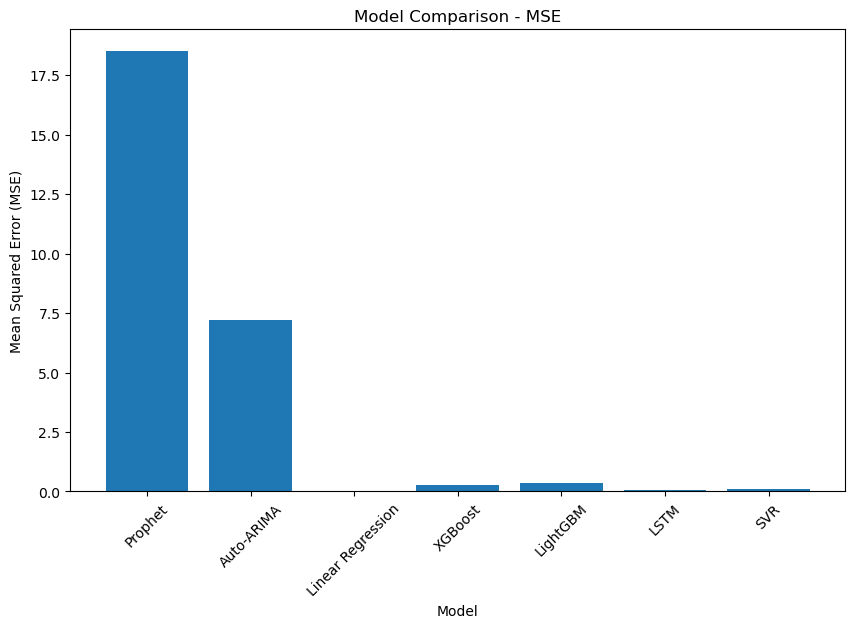

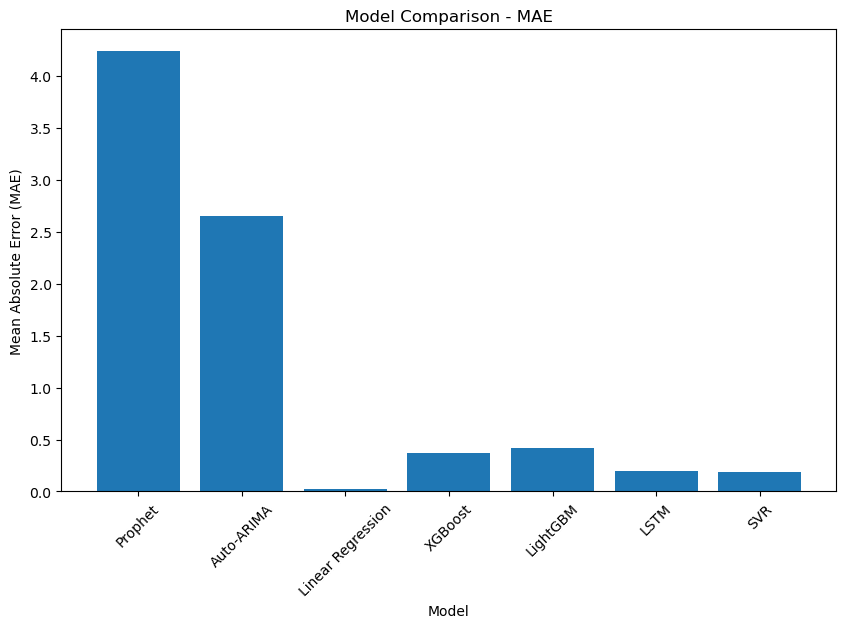

In [ ]:
# Section 11: Compare Models
def compare_models(models: Dict[str, Tuple[Any, float, float]]) -> None:
    """Compare the performance of different models."""
    model_names, mse_scores, mae_scores = zip(*[(name, mse, mae) for name, (_, mse, mae) in models.items()])

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, mse_scores)
    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, mae_scores)
    plt.xlabel('Model')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Comparison - MAE')
    plt.xticks(rotation=45)
    plt.show()

models = {
    'Prophet': (prophet_model, prophet_mse, prophet_mae),
    'Auto-ARIMA': (auto_arima_model, auto_arima_mse, auto_arima_mae),
    'Linear Regression': (linear_regression_model, linear_regression_mse, linear_regression_mae),
    'XGBoost': (xgboost_model, xgboost_mse, xgboost_mae),
    'LightGBM': (lightgbm_model, lightgbm_mse, lightgbm_mae),
    'LSTM': (lstm_model, lstm_mse, lstm_mae),
    'SVR': (svr_model, svr_mse, svr_mae),
}

compare_models(models)


In [ ]:
# Section 12: Train Ensemble Model
def train_ensemble(models: list, X: pd.DataFrame, y: pd.Series) -> Tuple[VotingRegressor, float, float]:
    """Train an ensemble model."""
    ensemble = VotingRegressor(estimators=models)
    mse, mae = time_series_cv(ensemble, X, y)
    logger.info(f"Ensemble model trained. MSE: {mse:.4f}, MAE: {mae:.4f}")
    return ensemble, mse, mae

ensemble_model, ensemble_mse, ensemble_mae = train_ensemble([
    ('linear', linear_regression_model),
    ('xgboost', xgboost_model),
    ('lightgbm', lightgbm_model)
], X_selected, y)

logger.info(f"Ensemble - MSE: {ensemble_mse:.4f}, MAE: {ensemble_mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 10
[LightGBM] [Info] Start training from score -1.026305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024-05-18 10:38:17,958 - INFO - Cross-validation results - MSE: 0.1418, MAE: 0.2647
2024-05-18 10:38:17,959 - INFO - Ensemble model trained. MSE: 0.1418, MAE: 0.2647
2024-05-18 10:38:17,961 - INFO - Ensemble - MSE: 0.1418, MAE: 0.2647


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

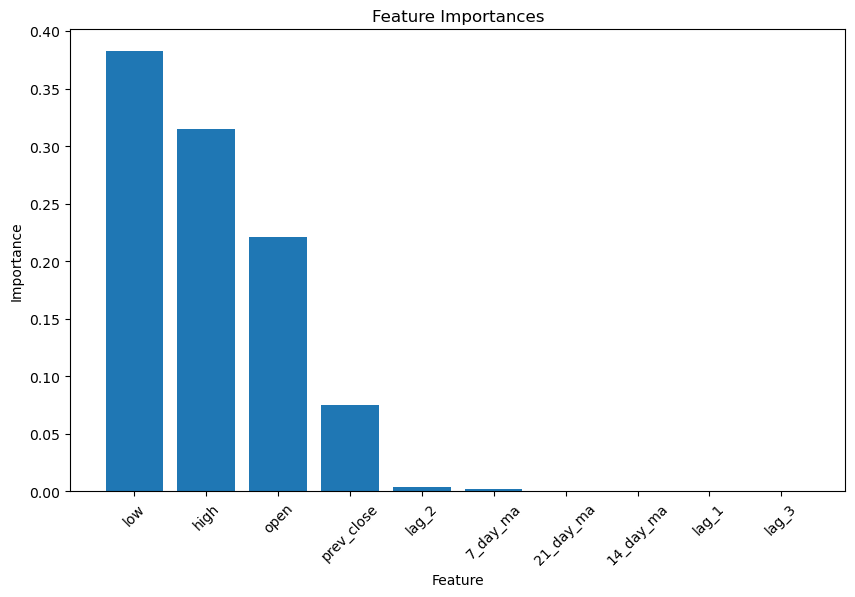

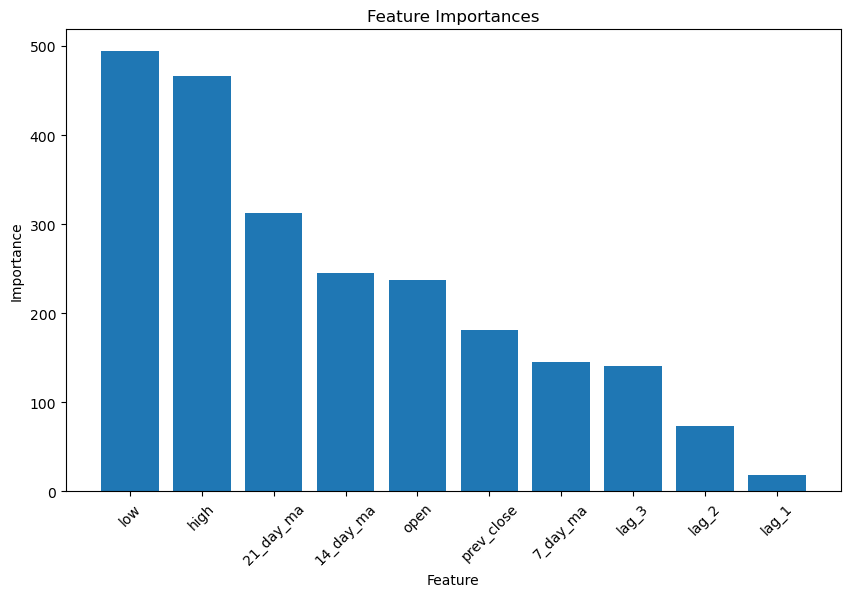

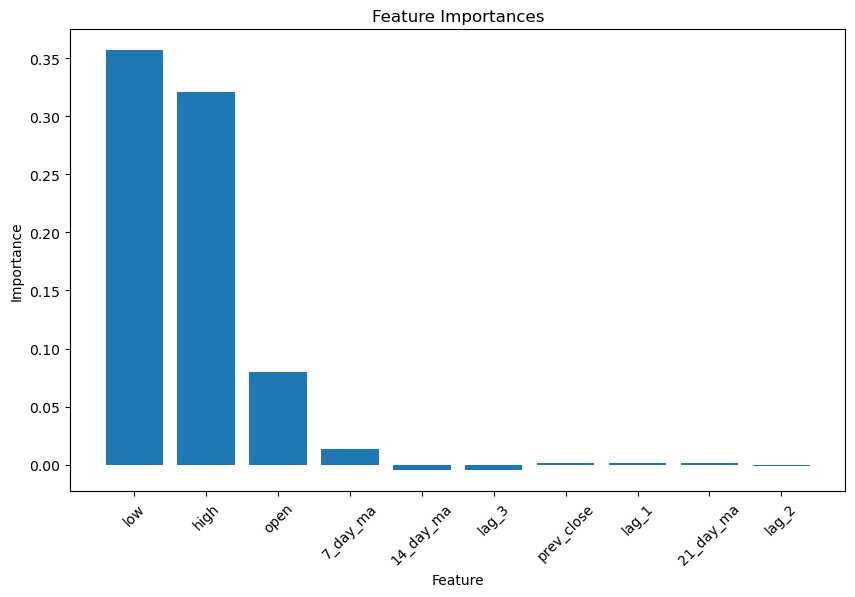

In [ ]:
# Section 13: Analyze Feature Importance
def analyze_feature_importance(model: Any, feature_names: list) -> None:
    """Analyze and plot feature importance for models that support it."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.show()
    elif hasattr(model, 'coef_'):
        importances = model.coef_
        indices = np.argsort(np.abs(importances))[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.show()
    else:
        logger.info("Model does not support feature importance analysis.")

analyze_feature_importance(xgboost_model, X_selected.columns)
analyze_feature_importance(lightgbm_model, X_selected.columns)
analyze_feature_importance(linear_regression_model, X_selected.columns)


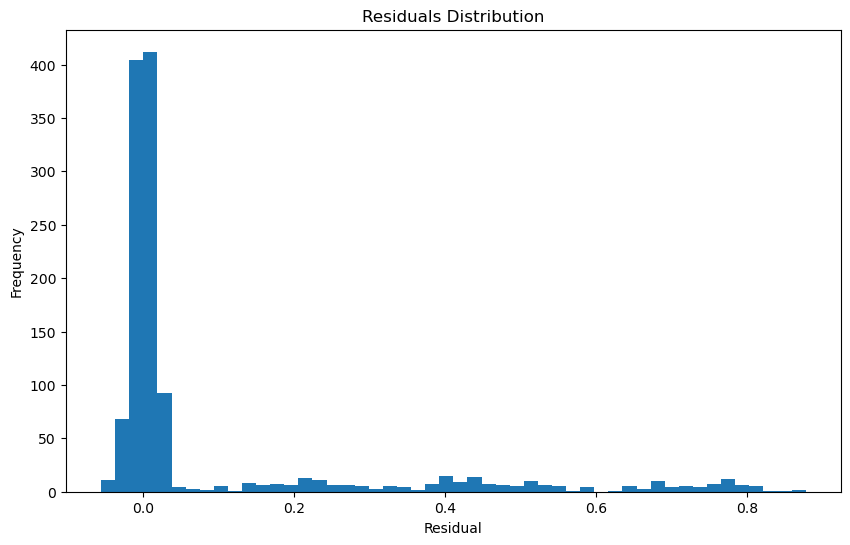

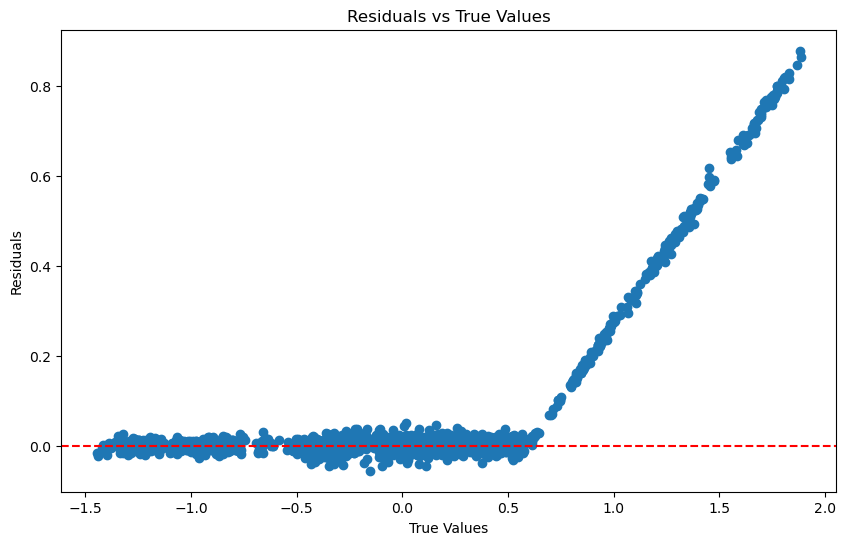

In [ ]:
# Section 14: Analyze Residuals
def analyze_residuals(true: pd.Series, predicted: np.ndarray) -> None:
    """Analyze residuals of the model predictions."""
    residuals = true - predicted
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50)
    plt.title('Residuals Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(true, residuals)
    plt.title('Residuals vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.axhline(0, color='r', linestyle='--')
    plt.show()

ensemble_pred = ensemble_model.predict(X_selected)
analyze_residuals(y, ensemble_pred)
